# Animated Aftershock Script

This is a beta script which will take a geonet quake ID and create an animated figure of the aftershock location, with size dependent on magnitude.

In [118]:
#importing relevant modules
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.basemap import Basemap
import os
import requests
import dateutil.parser
from datetime import timedelta, datetime
from obspy import UTCDateTime

### User input here 
Enter the quake ID, length of time in minutes and a file name, then "run all cells"

In [140]:
start = "2020-01-01T00:00:00"
interval = 3600 #interval in seconds
timelength = 720 #total length of time to examine, in units of above interval
filename = "test" #string of filename

Function follows below:

In [158]:
def aftershock_animation(start, interval, timelength, filename):
    
    """This function takes a start time and duration, and returns a map animation
    of earthquakes for New Zealand with points which fade!
    
    Data taken from the Geonet API. Some default parameters: by default the function
    pulls 365 days worth of data after the initiation, this can be changed. The basemap
    parameters are arbitrarily centred around NZ"""
      
    #converts start string into datetime object format
    starttime = dateutil.parser.isoparse(start)
    endtime = starttime + timedelta(days = 62) #end time, 5 days after, increase if needed
    
    #strings of times for wfs query
    start, end = starttime.strftime('%Y-%m-%dT%H:%M:%S'), endtime.strftime('%Y-%m-%dT%H:%M:%S')
   
    #wfs query. For further info see wfs.geonet.org.nz
    quakejson = requests.get("http://wfs.geonet.org.nz/geonet/ows?service=WFS&version=1.0.0&request="
                             "GetFeature&typeName=geonet:quake_search_v1&outputFormat=json&cql_filter="
                             "origintime>=" + start + "+AND+origintime<=" + end + 
                             "+AND+BBOX(origin_geom,167,-34,179,-48)").json()    
    #empty lists to iterate to from json file
    
    #empty lists to iterate to from json file
    lat, lon, mag, time, depth = ([] for i in range(5)) #empty lists for iterating
    #for loop populated said json files
    for a in range(len(quakejson['features'])):
        lon.append(quakejson['features'][a]['geometry']['coordinates'][0])
        lat.append(quakejson['features'][a]['geometry']['coordinates'][1])
        mag.append(quakejson['features'][a]['properties']['magnitude'])
        time.append(UTCDateTime(quakejson['features'][a]['properties']['origintime']))
        depth.append(quakejson['features'][a]['properties']['depth'])
    
    #Dataframe of quake info from above
    df = pd.DataFrame({"lat":lat, "lon":lon, "time":time,"mag":mag, "depth":depth})
    
    #colors for colormap in rgba format. The final value represents the increasing alpha
    colors = [[0.8,0,0,0],[0.8,0,0,0.3],[0.8,0,0,0.6]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    #sort dataframe by origin time
    df = df.sort_values(by="time")
    df = df[df.mag > 0] #exclude magnitudes less than 0 or script dies
    
    #Initiate plot
    fig, ax = plt.subplots(figsize = (10, 10), dpi = 100)
    ax=fig.add_axes([0,0,1,1]) #removing whitespace
    #Basemap plot - world topo map can be subbed for preferred map
    
    m = Basemap(llcrnrlon = 162, llcrnrlat = -50, urcrnrlon = 185 , urcrnrlat = -32, epsg = 2193, projection = 'tmerc')       
    m.arcgisimage(service = "World_Topo_Map", xpixels = 1000, dpi = 100)    
    
    #timelist creates a timestamp for every minute, up to a defined user limit.
    #this is used to create a frame for every minute, showing all quakes prior to said stamp
    timelist = [UTCDateTime(starttime) + interval * x for x in range(timelength)]
    #Strings of above to plot as annotation
    stime = [str(x) for x in timelist]
    #converting lat lon to matplotlib coords
    x,y = m(list(df['lon']), list(df['lat']))
    #empty lists for animation function
    xval, yval, intensity = [], [], []
    #Defining initial blank plot to offset to                                           
    scat = ax.scatter(xval, yval, marker = "o", c = [], cmap = cmap,
                         vmin = 0, vmax =1)   
    #messy part defining size of legend elements, probably should be loop
    
    l2 = plt.scatter([],[], s = 2**3.2*2,  c= 'crimson')
    l3 = plt.scatter([],[], s = 3**3.2*2,  c= 'crimson')
    l4 = plt.scatter([],[], s = 4**3.2*2,  c= 'crimson')
    l5 = plt.scatter([],[], s = 5**3.2*2,  c= 'crimson')
    l6 = plt.scatter([],[], s = 6**3.2*2,  c= 'crimson')
    l7 = plt.scatter([],[], s = 7**3.2*2,  c= 'crimson')
    l8 = plt.scatter([],[], s = 8**3.2*2,  c= 'crimson')
    #legend labels 
    labels = [str(x + 1) + "-" + str(x + 2) for x in range(7)]
    #call for legend 
    plt.legend([l2,l3,l4,l5,l6,l7,l8], labels, title = "Magnitude", loc = 'lower center', 
               labelspacing = 1, ncol = 7, borderpad = 1.7, columnspacing = 2.3, handletextpad = 1.2, scatterpoints =1 )
    
    
    #annotations - first one is the timestamp, second one is a count of the earthquakes
    
    annotation = ax.annotate(str(stime[0]), xy=(625, 950), xycoords='axes pixels', 
                             fontsize=14, c ='black')
    annotationcount = ax.annotate("Earthquake count: 0", xy = (20, 950), xycoords='axes pixels', 
                                  fontsize = 17, c = 'black')
    annotation.set_animated(True)
    annotationcount.set_animated(True) 
    #set aspect of map automatically
    ax.set_aspect('auto')

    #"initial" blank function, negative values help hide "initial" circle
    def init():
        scat.set_offsets([[],[]])
        return scat, annotation, annotationcount
    
    #function to call within animation function to update values with
    def new_values(b):
        nonlocal x, y
        x1 = x[b]
        y1 = y[b]
        z = list(df["mag"][:b])
        return [x1],[y1], z
    
    #complex update function, calls nonlocal empty nonlocal variables and updates
    def update(a):
        nonlocal intensity, xval, yval
        #dataframe just of quakes before timestamp "a"
        df2 = df[df['time'] < timelist[a]]
        #calls new values function for all events before a
        new_xvals, new_yvals, mags= new_values(len(df2))
        #extending lists to include these values
        xval.extend(new_xvals)
        yval.extend(new_yvals)
        
        #updates scatter plot locations and size
        scat.set_offsets(np.c_[xval, yval])
        scat.set_sizes([(int(str(x)[0])+1)**3.2 * 2 for x in mags])
        #sets fade depending on time since appearance
        intensity = np.concatenate((np.array(intensity)*0.96, np.ones(len(new_xvals))))
        scat.set_array(intensity)
        #animates annotation
        annotation.set_text(stime[a])
        annotationcount.set_text("Earthquake count: " + str(len(df2)))
        return scat, annotation, annotationcount
    #function to write animation to an mp4, with the defined filename (automatically as an mp4)
    ani = animation.FuncAnimation(fig, update, init_func=init, blit=False, frames = len(timelist))
    writer = FFMpegWriter(fps=25, bitrate=1800) #change fps if desired
    ani.save((filename + ".mp4"), writer=writer)

#### Function called using variables defined above

/opt/conda/envs/gha/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


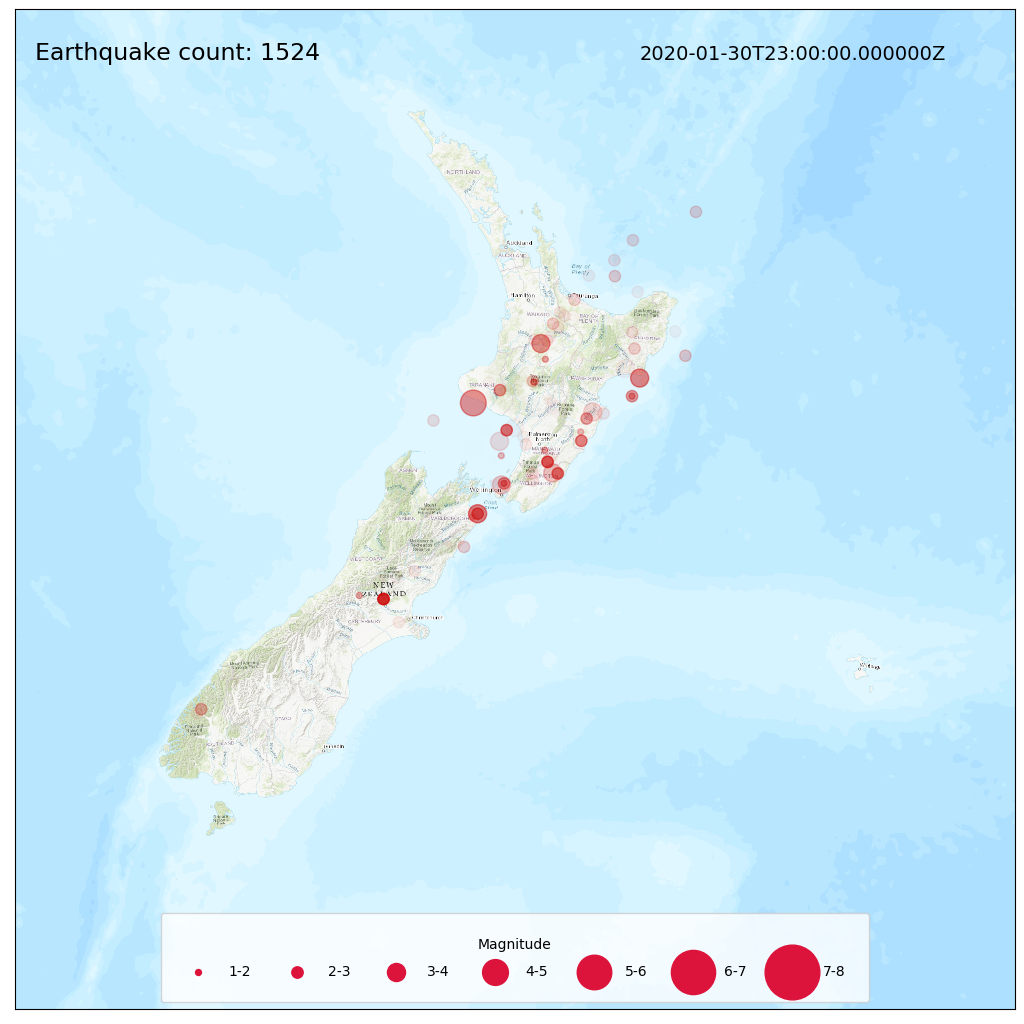

In [159]:
aftershock_animation(start, interval, timelength, filename)